In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy.integrate as integrate
from matplotlib import rcParams
rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [2]:
# Konstanten in SI
M_STAR=1
MU1=3e-3
MU2=1e-3
M1=3e-3*M_STAR
M2=1e-3*M_STAR

G=1
R_0=1 #1 au

SIGMA_0=1e-3*M_STAR *R_0**(-2)
SIGMASLOPE=1.5

ALPHAVISCOSITY=1e-3       
TSLOPE=0.5           
FLARINGINDEX=(-TSLOPE +1 ) /2           
H_0=0.06
SIGMARATIO=0.1   #for kanagawa
J=TSLOPE+SIGMASLOPE

R_IN=np.arange(1,10,0.001)*R_0
R_OUT=R_IN *2**(2/3)*R_0

In [16]:
#functions for the lindblad resonance locations

def omega_kepler(r):
    return np.sqrt(G*M_STAR/(r**3))

def surface_density(r):
    return SIGMA_0* (r/R_0)**(-SIGMASLOPE)
def aspect_ratio(r):
    return H_0 *(r/R_0)**FLARINGINDEX

def r_lim_k(r):
    return r-aspect_ratio(r)*r *2/3 ,r+aspect_ratio(r)*r *2/3

def r_lim_K(r,epsilon):
    return r+epsilon*aspect_ratio(r) *r  *2/3

def vk(r):
    return np.sqrt(G*M_STAR/r)

def cs(r):
    return aspect_ratio(r)*vk(r)

def press(r):
    return surface_density(r)*cs(r)**2

def dfdlnr(f,r,*args):
    rp       = r * (1+1e-5)
    lnr      = np.log(r)
    lnrp     = np.log(rp)
    return (f(rp,*args)-f(r,*args))/(lnrp-lnr)
                                     
def dlnsigmadlnr(r):
    return dfdlnr(sigma,r)/sigma(r)
                                     
def dlnpdlnr(r):
    return dfdlnr(press,r)/press(r)
                                     
def omphi(r):
    return omega_kepler(r) * np.sqrt(1+(cs(r)**2/vk(r)**2)*dlnpdlnr(r))
                                     
def kappa(r):
    qkap = -dfdlnr(omphi,r)/omphi(r)
    return np.sqrt(2*(2-qkap))*omphi(r)

In [4]:
#Lindblad resonace locations from GT with l=m and l=/m
def Goldreich(rp,m,l,epsilon):
    rv= ((m+epsilon)/l)**(2/3) *rp
    
    if epsilon==1 and rv < r_lim_K(rp*R_0,1)/R_0:
        return r_lim_K(rp*R_0,1)/R_0
        
    elif epsilon==-1 and rv > r_lim_K(rp*R_0,-1)/R_0:
        return r_lim_K(rp*R_0,-1)/R_0
    else:
        return rv


In [18]:
#Lindblad resonace locations D_p
def Dpnew(r,r0,m):
    return kappa(r)**2-m**2*(omphi(r)-omega_kepler(r0))**2

def Dp_positions(rp_value,m):
    x = np.logspace(-2,2, 1000000)
    pos_m_in=[]
    pos_m_out=[]
    
    tmp =Dpnew(x*R_0, r0=rp_value*R_0,m=m)
    idx_in=np.where(np.sign(tmp[1:]*tmp[:-1])==-1)[0][0]
    idx_out=np.where(np.sign(tmp[1:]*tmp[:-1])==-1)[0][1]


    if m==1:
        
        if (x[idx_out]+x[idx_out+1])/2 < r_lim_K(rp_value*R_0,1)/R_0:
            pos_m_out.append(r_lim_K(rp_value*R_0,1)/R_0)
        else:
            pos_m_out.append((x[idx_out]+x[idx_out+1])/2)
            
    else:
       
        if (x[idx_out]+x[idx_out+1])/2 < r_lim_K(rp_value*R_0,1)/R_0:
            pos_m_out.append(r_lim_K(rp_value*R_0,1)/R_0)
        else:
            pos_m_out.append((x[idx_out]+x[idx_out+1])/2)
            
        if (x[idx_in]+x[idx_in+1])/2 > r_lim_K(rp_value*R_0,-1)/R_0:
            pos_m_in.append(r_lim_K(rp_value*R_0,-1)/R_0)
        else:
            pos_m_in.append((x[idx_in]+x[idx_in+1])/2)

    return pos_m_in[0], pos_m_out[0]


#Lindblad resonace locations D_p_star
                                  
def Dstarpnew(r,r0,m):
    return kappa(r)**2-m**2*(omphi(r)-omega_kepler(r0))**2+(m*cs(r)/r)**2

def Dstarp_positions(rp_value,m):
    x = np.logspace(-1,1.3, 1000000)
    pos_m_in=[]
    pos_m_out=[]
    
    tmp =Dstarpnew(x*R_0, r0=rp_value*R_0,m=m)
    idx_in=np.where(np.sign(tmp[1:]*tmp[:-1])==-1)[0][0]
    idx_out=np.where(np.sign(tmp[1:]*tmp[:-1])==-1)[0][1]


    if m==1:
        
        if (x[idx_out]+x[idx_out+1])/2 < r_lim_K(rp_value*R_0,1)/R_0:
            pos_m_out.append(r_lim_K(rp_value*R_0,1)/R_0)
        else:
            pos_m_out.append((x[idx_out]+x[idx_out+1])/2)
            
    else:
       
        if (x[idx_out]+x[idx_out+1])/2 < r_lim_K(rp_value*R_0,1)/R_0:
            pos_m_out.append(r_lim(rp_value*R_0,1)/R_0)
        else:
            pos_m_out.append((x[idx_out]+x[idx_out+1])/2)
            
        if (x[idx_in]+x[idx_in+1])/2 > r_lim_K(rp_value*R_0,-1)/R_0:
            pos_m_in.append(r_lim_K(rp_value*R_0,-1)/R_0)
        else:
            pos_m_in.append((x[idx_in]+x[idx_in+1])/2)
        
    
    return pos_m_in[0], pos_m_out[0]



In [6]:
#Lindblad resonace locations D
def r_in(rp,m):
    return (1-1/m)**(2/3) *rp

def r_out(rp,m):
    return (1+1/m)**(2/3) *rp

def D_positions(rp_value,m):
    x = np.logspace(-2,2, 1000000)
    pos_m_in=[]
    pos_m_out=[]

    if m==1:
        
        if r_out(rp_value,1)< r_lim_K(rp_value*R_0,1)/R_0:
            pos_m_out.append(r_lim_K(rp_value*R_0,1)/R_0)
        else:
            pos_m_out.append(r_out(rp_value,1))
            
    else:
       
        if r_out(rp_value,m) < r_lim_K(rp_value*R_0,1)/R_0:
            pos_m_out.append(r_lim_K(rp_value*R_0,1)/R_0)
        else:
            pos_m_out.append(r_out(rp_value,m))
            
        if r_in(rp_value,m)> r_lim_K(rp_value*R_0,-1)/R_0:
            pos_m_in.append(r_lim_K(rp_value*R_0,-1)/R_0)
        else:
            pos_m_in.append(r_in(rp_value,m))
        
    
    return pos_m_in[0], pos_m_out[0]


In [14]:
#Lindblad resonace locations D_K
def D_K(r,rp,m):
    return m**2 *(omega_kepler(r)-omega_kepler(rp))**2 -omega_kepler(r)**2 *(1+m**2 *aspect_ratio(r)**2)

def D_K_positions(rp_value,m):
    x = np.logspace(-2,2, 1000000)
    pos_m_in=[]
    pos_m_out=[]
    
    tmp =D_K(x*R_0, rp=rp_value*R_0,m=m)
    idx_in=np.where(np.sign(tmp[1:]*tmp[:-1])==-1)[0][0]
    idx_out=np.where(np.sign(tmp[1:]*tmp[:-1])==-1)[0][1]


    if m==1:
        
        if (x[idx_out]+x[idx_out+1])/2 < r_lim_K(rp_value*R_0,1)/R_0:
            pos_m_out.append(r_lim_K(rp_value*R_0,1)/R_0)
        else:
            pos_m_out.append((x[idx_out]+x[idx_out+1])/2)
            
    else:
       
        if (x[idx_out]+x[idx_out+1])/2 < r_lim_K(rp_value*R_0,1)/R_0:
            
            pos_m_out.append(r_lim_K(rp_value*R_0,1)/R_0)
        else:
            pos_m_out.append((x[idx_out]+x[idx_out+1])/2)
            
        if ((x[idx_in]+x[idx_in+1])/2) > (r_lim_K(rp_value*R_0,-1)/R_0):
            pos_m_in.append(r_lim_K(rp_value*R_0,-1)/R_0)
        else:
            pos_m_in.append((x[idx_in]+x[idx_in+1])/2)
        
    
    return pos_m_in[0], pos_m_out[0]


In [19]:
rp_value=1
mm=np.arange(2,40,1)

#create inner resonances
D_K_pos_in=[D_K_positions(rp_value,m)[0] for m in mm]
D_pos_in=[D_positions(rp_value,m)[0] for m in mm]
Dp_pos_in=[Dp_positions(rp_value,m)[0] for m in mm]
Dstarp_pos_in=[Dstarp_positions(rp_value,m)[0] for m in mm]
goldreich_pos_in_lm=[Goldreich(rp_value,m,m,-1) for m in mm]
goldreich_pos_in_lmp1=[Goldreich(rp_value,m,m+1,-1) for m in mm]
goldreich_pos_in_lmm1=[Goldreich(rp_value,m,m-1,-1) for m in mm]


''

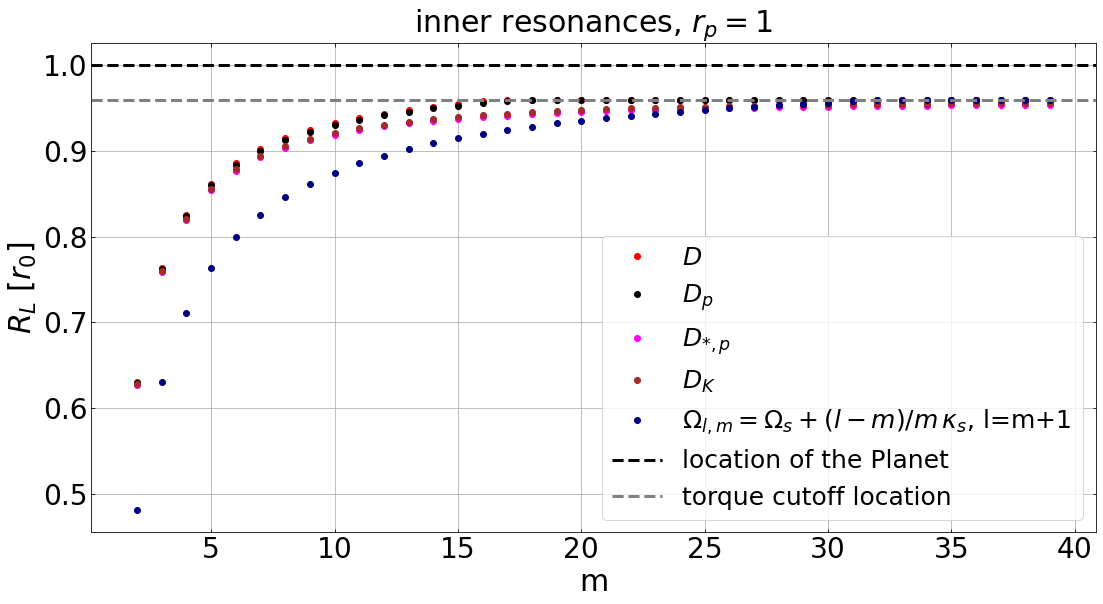

In [20]:
#plot all the inner resonances
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (18, 9))

ax.plot(mm,D_pos_in,'.',markersize=12, color='red',label=r'$D$')
ax.plot(mm,Dp_pos_in,'.',markersize=12, color='black',label=r'$D_{p}$')
ax.plot(mm,Dstarp_pos_in ,'.',markersize=12,color='magenta',label=r'$D_{*,p}$')
ax.plot(mm,D_K_pos_in,'.',markersize=12, color='brown',label=r'$D_{K}$')
ax.plot(mm,goldreich_pos_in_lmp1,'.',markersize=12,color= 'navy',label=r'$\Omega_{l,m} = \Omega_s + (l-m)/m \,\kappa_s $, l=m+1 ')
ax.set_title(r'inner resonances, $r_{p}=1$', fontsize=30)

ax.axhline(rp_value,ls='--', lw = 3,color= 'black',label='location of the Planet')
ax.axhline(r_lim_K(rp_value*R_0,-1)/R_0,ls='--',lw = 3,color= 'grey', label='torque cutoff location')
ax.set_ylabel(r'$R_L$ [$r_0$]',fontsize=30)
ax.set_xlabel(r'm',fontsize=30)
ax.yaxis.tick_left()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both',direction="in")
plt.yticks(fontsize = 28)
plt.xticks(fontsize = 28)

plt.grid()
ax.legend(fontsize=25)

#plt.savefig('in Resonanz ppnicht.png')

;

''

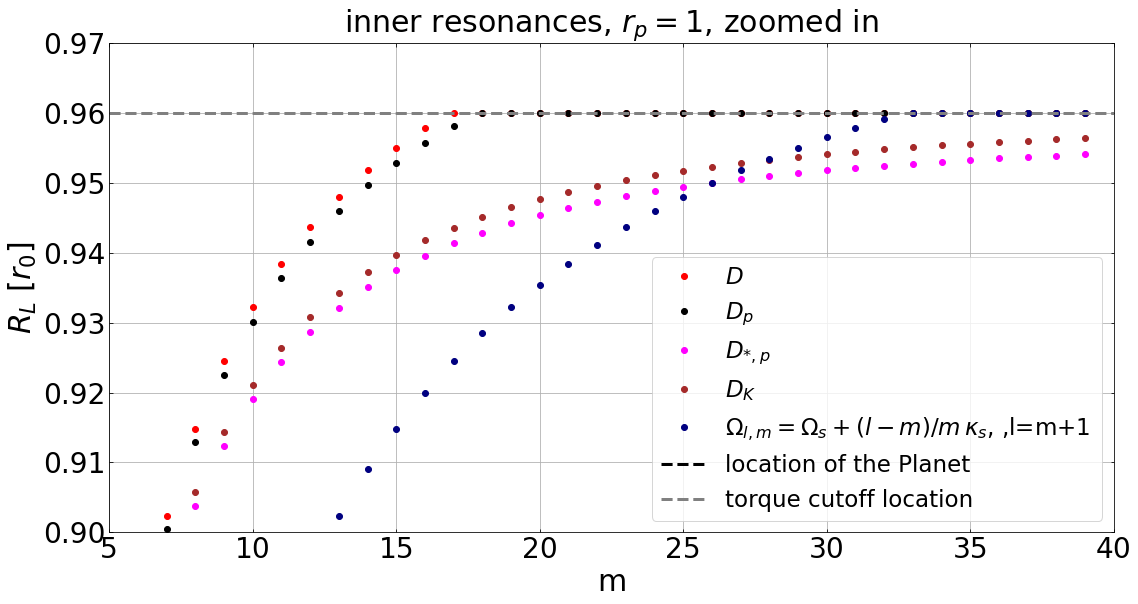

In [21]:
#plot all the inner resonances, zoomed in
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (18, 9))

ax.plot(mm,D_pos_in,'.',markersize=12, color='red',label=r'$D$')
ax.plot(mm,Dp_pos_in,'.',markersize=12, color='black',label=r'$D_{p}$')
ax.plot(mm,Dstarp_pos_in ,'.',markersize=12,color='magenta',label=r'$D_{*,p}$')
ax.plot(mm,D_K_pos_in,'.',markersize=12, color='brown',label=r'$D_{K}$')
ax.plot(mm,goldreich_pos_in_lmp1,'.',markersize=12,color= 'navy',label=r'$\Omega_{l,m} = \Omega_s + (l-m)/m \,\kappa_s $, ,l=m+1 ')
ax.set_title(r'inner resonances, $r_{p}=1$, zoomed in',fontsize=30)

ax.axhline(rp_value,ls='--',lw = 3, color= 'black',label='location of the Planet')
ax.axhline(r_lim_K(rp_value*R_0,-1)/R_0,ls='--',lw = 3,color= 'grey', label='torque cutoff location')

ax.set_ylim(0.9,0.97)
ax.set_xlim([5,40])
ax.set_ylabel(r'$R_L$ [$r_0$]',fontsize=30)
ax.set_xlabel(r'm',fontsize=30)
ax.yaxis.tick_left()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both',direction="in")
plt.grid()
ax.legend(fontsize=23)
plt.yticks(fontsize = 28)
plt.xticks(fontsize = 28)
#plt.savefig('in Resonanz zoomednichthich.png')

;

 grün, magenta, rot und braun liegen alle so ziemlich exact übereinander

In [ ]:
#create outer resonances
D_K_pos_out=[D_K_positions(rp_value,m)[1] for m in mm]
D_pos_out=[D_positions(rp_value,m)[1] for m in mm]
Dp_pos_out=[Dp_positions(rp_value,m)[1] for m in mm]
Dstarp_pos_out=[Dstarp_positions(rp_value,m)[1] for m in mm]
goldreich_pos_lm=[Goldreich(rp_value,m,m,1) for m in mm]
goldreich_pos_lmp1=[Goldreich(rp_value,m,m+1,1) for m in mm]
goldreich_pos_lmm1=[Goldreich(rp_value,m,m-1,1) for m in mm]


In [ ]:
#plot all the outer resonances
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (18,9))

ax.plot(mm,D_pos_out,'.',markersize=12, color='red',label=r'$D$')
ax.plot(mm,Dp_pos_out,'.',markersize=12, color='black',label=r'$D_{p}$')
ax.plot(mm,Dstarp_pos_out ,'.',markersize=12,color='magenta',label=r'$D_{*,p}$')
ax.plot(mm,D_K_pos_out,'.',markersize=12, color='brown',label=r'$D_{K} $')
ax.plot(mm,goldreich_pos_lmm1,'.',markersize=12,color= 'grey',label=r'$\Omega_{l,m} = \Omega_s + (l-m)/m \,\kappa_s $, l=m-1 ')
ax.set_title(r'outer resonances, $r_{p}=1$', fontsize=30)

ax.axhline(rp_value,ls='--', lw=3,color= 'black',label='location of the Planet')
ax.axhline(r_lim_K(rp_value*R_0,1)/R_0,ls='--',lw=3,color= 'grey', label='torque cutoff location')

ax.set_ylabel(r'$R_L$ [$r_0$]',fontsize=30)
ax.set_xlabel(r'm',fontsize=30)
ax.yaxis.tick_left()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both',direction="in")
plt.grid()
plt.yticks(fontsize = 28)
plt.xticks(fontsize = 28)
ax.legend(fontsize=23)
#plt.savefig('out Resonanz nichthoich.png')

;

In [ ]:
#plot all the outer resonances, zoomed in
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (18, 9))

ax.plot(mm,D_pos_out,'.',markersize=12, color='red',label=r'$D$')
ax.plot(mm,Dp_pos_out,'.',markersize=12, color='black',label=r'$D_{p}$')
ax.plot(mm,Dstarp_pos_out ,'.',markersize=12,color='magenta',label=r'$D_{*,p}$')
ax.plot(mm,D_K_pos_out,'.',markersize=12, color='brown',label=r'$D_{K}$')
ax.plot(mm,goldreich_pos_lmm1,'.',markersize=12,color= 'grey',label=r'$\Omega_{l,m} = \Omega_s + (l-m)/m \,\kappa_s $, l=m-1 ')
ax.set_title(r'outer resonances, $r_{p}=1$, zoomed in',fontsize=30)

ax.axhline(rp_value,ls='--',lw=3, color= 'black',label='location of the Planet')
ax.axhline(r_lim_K(rp_value*R_0,1)/R_0,ls='--',lw=3,color= 'grey', label='torque cutoff location')

ax.set_ylabel(r'$R_L$ [$r_0$]',fontsize=30)
ax.set_xlabel(r'm',fontsize=30)
ax.yaxis.tick_left()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both',direction="in")
plt.grid()
ax.set_xlim([4,40])
ax.set_ylim(1.03,1.15)
ax.legend(fontsize=23)
plt.yticks(fontsize = 28)
plt.xticks(fontsize = 28)
#plt.savefig('out Resonanz zoomed nichthoch.png')

;